In [1]:
REPORT_PATH_TEMPLATE = '../out/reports/bots_band_%s_target_%s.pkl'
# or overrided REPORT_PATH_TEMPLATE
REPORT_PATH = None

BAND = '1k'
TARGET_CONFIDENCE = '0.5'
FOCUS_BINS = 20
FIGS_PATH = '../out/images'
TABLE_CHANGED_FEATURES_THRESHOLD = 2
WEIGHTED_EPSILONS = [2, 3, 5, 10]
HIGH_EPSILONS = [5, 10, 100, 500, 1000]
BEST_FIRST_EPSILON = None
FIGWIDTH = 8.5
FIGHEIGHT = 6.5
SAVE_PLOTS = False
MARKERS = ['D', '*', 'o', 's', '^', 'P']
P_NORM = 1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.extend(['.', '..'])

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict

from trickster.optim import LpSpace

import pickle

import plot_params

### Utilities

In [5]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        return results
    
def group_by_key(data, key):
    obj = defaultdict(list)
    for d in data:
        value = d[key]
        obj[value].append(d)        
    return obj

def save_fig(fig, name_template, *args, **kwargs):
    fig.savefig(os.path.join(FIGS_PATH, name_template.format(*args, **kwargs)))

In [6]:
def get_runtime_improvement(ast_results, ucs_results):
    assert ast_results['dataset_index'].equals(ucs_results['dataset_index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    # Get the measurements
    ucs_expansions = ucs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    ucs_runtimes = ucs_results['runtime']
    ast_runtimes = ast_results['runtime']
    
    # Obtain indexes that would sort the UCS expansions array.
    idxs = np.argsort(ucs_expansions.values)
    
    # Use indexes to sort UCS and A* expansion counts and runtimes.
    ucs_expansions_sorted = ucs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    ucs_runtimes_sorted = ucs_runtimes.values[idxs]
    ast_runtimes_sorted = ast_runtimes.values[idxs]
    
    improvement = (ucs_expansions_sorted / ast_expansions_sorted)
    return improvement, ast_runtimes_sorted, ucs_runtimes_sorted, \
           ast_expansions_sorted, ucs_expansions_sorted

In [7]:
def get_path_cost_increase(ast_results, ucs_results):
    assert ast_results['dataset_index'].equals(ucs_results['dataset_index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    print(ucs_results.columns)
    
    # Get the expansion arrays.
    ucs_path_cost = ucs_results['path_cost']
    ast_path_cost = ast_results['path_cost']
    
    # Obtain indexes that would sort the ucs expansions array.
    idxs = np.argsort(ucs_path_cost.values)
    
    # Use indexes to sort ucs and A* expansions arrays and compute improvement. 
    ucs_path_cost_sorted = ucs_path_cost.values[idxs]
    ast_path_cost_sorted = ast_path_cost.values[idxs]
    
    increase = (ast_path_cost_sorted / ucs_path_cost_sorted)
    return increase, ast_path_cost_sorted, ucs_path_cost_sorted

In [8]:
def get_feature_names(quantized_features):
    feature_names = ['source_identity']
    for x in quantized_features:
        split = x.split('_')
        if 'source' in split:
            continue
        else:
            feat = '_'.join(split[:-1])
            if feat not in feature_names:
                feature_names.append(feat)
    return feature_names

In [9]:
def get_feature_value_pairs(xs):
    obj = {}
    for x in xs:
        split = x.split('_')
        if 'source' in split:
            if 'present' in split:
                feature = 'source_identity'
                value = '_'.join(split[2:3])
                if feature in obj:
                    obj[feature].append(value)
                else:
                    obj[feature] = [value]
        else:
            feature = '_'.join(split[:-1])
            value = split[-1]
            obj[feature] = value
    return obj

### Load data

In [10]:
# Load results from running adversarial search on bot dataset.
if REPORT_PATH is None:
    REPORT_PATH = REPORT_PATH_TEMPLATE % (BAND, TARGET_CONFIDENCE)
results = load_results(REPORT_PATH)

### Table with adversarial examples

In [11]:
ast_results = group_by_key(results, 'epsilon').get(1)
results_bin = group_by_key(ast_results, 'bins').get(FOCUS_BINS)[0]

search_results = results_bin['search_results']
features = results_bin['features']

feature_names = get_feature_names(features)
changed_features = set()

df = pd.DataFrame(columns=['confidence'] + feature_names)

for i, row in search_results.iterrows():

    # Find which features are set.
    original = row['x_features'].astype(bool)
    adversarial = row['x_adv_features'].astype(bool)
    
    # Get a dictionary of features (keys) and values.
    orig_feat_vals = get_feature_value_pairs(features[original])
    adv_feat_vals = get_feature_value_pairs(features[adversarial])
        
    # The code below checks if there are at least 2 changed features.
    changed = 0
    temp_changed_features = set()
    
    try:
        for k in orig_feat_vals.keys():
            if orig_feat_vals[k] != adv_feat_vals[k]:
                changed += 1
                temp_changed_features.add(k)
                
    except KeyError as e:
        print('KeyError', e)
        continue
            
    if changed < TABLE_CHANGED_FEATURES_THRESHOLD:
        continue
        
    # Add the confidence scores to ease append to the dataframe.
    orig_feat_vals['confidence'] = row['init_confidence']
    adv_feat_vals['confidence'] = row['adv_confidence']
    
    # Keep track of changed features.
    changed_features = changed_features.union(temp_changed_features)
    
    # Append to the dataframe.
    df = df.append(orig_feat_vals, ignore_index=True)
    df = df.append(adv_feat_vals, ignore_index=True)

# Drop unchanged features.
unchanged_features = set(feature_names) - changed_features
df = df.drop(columns=unchanged_features)
df

# Convert to latex. 
# res = df.to_latex(index=False)


,confidence,source_identity,user_tweeted,user_retweeted,user_favourited,user_replied,lists_per_user,age_of_account_in_days,urls_count
0,0.120752,"[other, browser, mobile]","(6.0, 7.0]","(-0.001, 1.0]","(52.0, 207.8]","(-0.001, 1.0]","(0.011, 0.0143]","(2127.598, 2264.455]","(5.0, 6.0]"
1,0.544546,"[browser, mobile]","(6.0, 7.0]","(-0.001, 1.0]","(207.8, 476.143]","(-0.001, 1.0]","(0.011, 0.0143]","(2127.598, 2264.455]","(5.0, 6.0]"
2,0.008606,[other],"(-0.001, 1.0]","(19.0, 32.0]","(-0.001, 4.0]","(26.0, 42.0]","(0.024, 0.0329]","(766.122, 849.108]","(16.0, 24.2]"
3,0.526738,"[mobile, osn]","(-0.001, 1.0]","(12.0, 19.0]","(-0.001, 4.0]","(26.0, 42.0]","(0.0188, 0.024]","(766.122, 849.108]","(16.0, 24.2]"
4,0.118470,"[other, browser, mobile]","(20.0, 27.0]","(19.0, 32.0]","(35990.095, 211890.704]","(18.0, 26.0]","(0.024, 0.0329]","(2450.073, 3332.802]","(16.0, 24.2]"
5,0.578171,"[browser, mobile]","(20.0, 27.0]","(12.0, 19.0]","(35990.095, 211890.704]","(18.0, 26.0]","(0.024, 0.0329]","(2450.073, 3332.802]","(16.0, 24.2]"
6,0.050031,[marketing],"(55.6, 766.0]","(-0.001, 1.0]","(772.24, 1164.881]","(-0.001, 1.0]","(0.05, 0.0962]","(1384.307, 1492.455]","(56.0, 806.0]"
7,0.511897,"[mobile, osn]","(27.0, 55.6]","(-0.001, 1.0]","(772.24, 1164.881]","(-0.001, 1.0]","(0.05, 0.0962]","(1384.307, 1492.455]","(56.0, 806.0]"
8,0.009900,[automation],"(13.0, 16.0]","(-0.001, 1.0]","(4.0, 52.0]","(-0.001, 1.0]","(0.05, 0.0962]","(1177.447, 1269.787]","(12.0, 16.0]"
9,0.512774,"[mobile, osn]","(13.0, 16.0]","(-0.001, 1.0]","(4.0, 52.0]","(1.0, 2.0]","(0.05, 0.0962]","(1269.787, 1384.307]","(12.0, 16.0]"


### Plot results over different bins

#### Record stats and metrics over different bins

In [12]:
results_by_bins = group_by_key(results, 'bins')
attack_perf_df = pd.DataFrame(columns=['bins', 'dataset_index', 'expansions', 'improvement', 'eps'])
clf_perf_df = pd.DataFrame(columns=['bins', 'accuracy', 'robustness'])
costs_df = pd.DataFrame(columns=['bins', 'dataset_index', 'eps', 'robustness', 'pathcost', 'pathcostincrease'])

models = []
ucs_results_by_bins = group_by_key(group_by_key(results, 'epsilon').get(0), 'bins')
for bins, items in results_by_bins.items():
    clf_perf_df = clf_perf_df.append({
            'bins': bins,
            'accuracy': items[0]['clf_score'],
        }, ignore_index=True)
    models.append(items[0]['classifier'])
    
    for item in items:
        ast_results = item['search_results']
        ucs_results = ucs_results_by_bins[bins][0]['search_results']
        
        ast_results = ast_results.sort_values('dataset_index')
        ucs_results = ucs_results.sort_values('dataset_index')
        assert ast_results['dataset_index'].equals(ucs_results['dataset_index'])
        
        item_data = zip(
            ast_results['dataset_index'],
            ast_results['runtime'],
            ast_results['nodes_expanded'],
            ucs_results['nodes_expanded'])
        
        # Record attack runtime performance vs. UCS.
        for index, ast_runtime, ast_expansions, ucs_expansions in item_data:           
            attack_perf_df = attack_perf_df.append(
                {
                    'bins': bins,
                    'dataset_index': index,
                    'eps': item['epsilon'],
                    'runtime': ast_runtime,
                    'expansions': ast_expansions,
                    'improvement': ucs_expansions / ast_expansions,
                },
                ignore_index=True
            )
        
        # Record attack cost performance vs. UCS.
        for index, ast_path_cost, ucs_path_cost in zip(
                ast_results['dataset_index'], ast_results['path_cost'], ucs_results['path_cost']):
            
            # Re-compute adv.robustness in R^m for each point.
            example = list(ast_results.query('dataset_index==%d' % index)['x_features'])[0]
            robustness = np.abs(item['classifier'].decision_function([example])[0]) \
                / np.linalg.norm(item['classifier'].coef_[0], ord=LpSpace(P_NORM).q)
            
            ucs_results.sort_values
            costs_df = costs_df.append(
                {
                    'bins': bins,
                    'dataset_index': index,
                    'eps': item['epsilon'],
                    'robustness': robustness,
                    'pathcost': ucs_path_cost,
                    'pathcostincrease': ast_path_cost / ucs_path_cost
                },
                ignore_index=True
            )

In [13]:
costs_df.pathcostincrease.max()

1.0

#### Compute model gradient sharpness

In [14]:
coefs = np.array([model.coef_[0] for model in models])
coefs_norm = []
for coef_vec in coefs:
    coef_vec_norm = np.array(coef_vec)
    coef_vec_norm += np.abs(np.min(coef_vec_norm))
    coef_vec_norm /= np.sum(np.abs(coef_vec_norm))
    coefs_norm.append(coef_vec_norm)
    
coefs_norm = np.array(coefs_norm)
sharpness = np.array([np.ediff1d(coef).mean() for coef in coefs_norm])

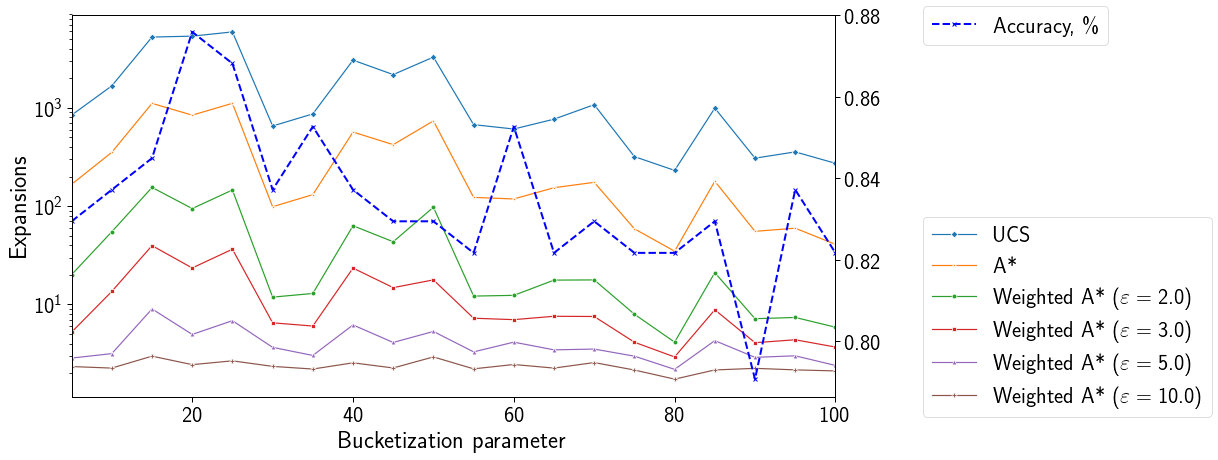

In [15]:
fig, ax = plt.subplots()

sns.lineplot(data=attack_perf_df.query('eps == 0'),
             x='bins', y='expansions', ax=ax, label='UCS', ci=None,
             marker=MARKERS[0])

sns.lineplot(data=attack_perf_df.query('eps == 1'),
             x='bins', y='expansions', ax=ax, label='A*', ci=None, 
             marker=MARKERS[1])

for i, eps in enumerate(WEIGHTED_EPSILONS):
    sns.lineplot(data=attack_perf_df.query('{0} - 0.1 < eps < {0} + 0.1'.format(eps)),
                 x='bins', y='expansions', ax=ax,
                 label='Weighted A* ($\\varepsilon = %1.1f$)' % eps,
                 ci=None, marker=MARKERS[i + 2])

if BEST_FIRST_EPSILON is not None:
    sns.lineplot(data=attack_perf_df.query('eps == %d' % BEST_FIRST_EPSILON),
                 x='bins', y='expansions', ax=ax, label='Best-first',
                 ci=None)

ax.set_ylabel('Expansions')
ax.set_xlabel('Bucketization parameter')
ax.set_xlim(5, 100)
ax.set_yscale('log')
legend_artist = ax.legend(bbox_to_anchor=(1.1, 0.5))

ax2 = ax.twinx()
ax2.plot(clf_perf_df.bins, clf_perf_df.accuracy,
         label='Accuracy, \%',
         linestyle='--', color='blue', marker='x', linewidth=2)
# ax2.plot(clf_perf_df.bins, clf_perf_df.robustness / clf_perf_df.robustness.max() * 100,
#          label='Relative* adv. robustness, \%',
#          linestyle='--', color='red', marker='v', linewidth=2.5)
# ax2.set_yscale('log')
legend_artist2 = ax2.legend(loc=2, bbox_to_anchor=(1.1, 1.05))

fig.set_figwidth(FIGWIDTH * 2)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'bots_different_bins_perf_band_{}_target_{}.pdf', BAND, TARGET_CONFIDENCE,
             bbox_extra_artists=[legend_artist, legend_artist2], bbox_inches='tight')

### Plot results for one bin

In [16]:
# Group the results by the required key.
results_by_key = group_by_key(results, 'epsilon')

RUNTIME_FACTOR = 1

expansion_improvements_by_eps = {}
ast_expansions_by_eps = {}
ast_runtimes_by_eps = {}
ucs_expansions = None
ucs_runtimes = None
for epsilon, items in results_by_key.items():
    for item in items:
        if item['bins'] != FOCUS_BINS:
            continue
        
        ast_results = item['search_results']
        ucs_results = ucs_results_by_bins.get(FOCUS_BINS)[0]['search_results']
        t = get_runtime_improvement(ast_results, ucs_results)
        (improvements, ast_runtimes_sorted, ucs_runtimes_sorted,\
         ast_expansions_sorted, ucs_expansions_sorted) = t
        ucs_expansions = ucs_expansions_sorted
        ucs_runtimes = ucs_runtimes_sorted * RUNTIME_FACTOR
        
        expansion_improvements_by_eps[epsilon] = np.array(improvements)
        ast_expansions_by_eps[epsilon] = np.array(ast_expansions_sorted)
        ast_runtimes_by_eps[epsilon] = np.array(ast_runtimes_sorted) * RUNTIME_FACTOR

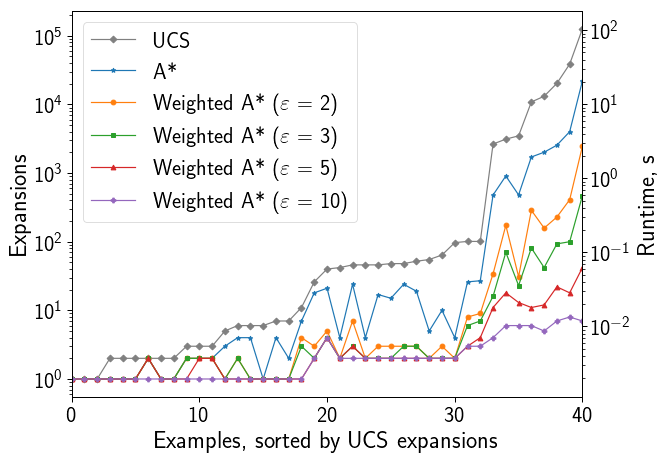

In [17]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(ucs_expansions, color='grey', label='UCS', marker=MARKERS[0])
ax2.plot(ucs_runtimes, color='grey', label='UCS',
         linestyle='None')

ax.plot(ast_expansions_by_eps[1], label='A*', marker=MARKERS[1])
ax2.plot(ast_runtimes_by_eps[1], label='A*',
         linestyle='None')

for i, eps in enumerate(WEIGHTED_EPSILONS):
    expansions = ast_expansions_by_eps[eps]
    runtimes = ast_runtimes_by_eps[eps]
    ax.plot(expansions, label='Weighted A* ($\\varepsilon$ = {})'.format(eps), marker=MARKERS[i + 2])
    ax2.plot(runtimes, label='Weighted A* ($\\varepsilon$ = {})'.format(eps),
             linestyle='None')
    
ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Expansions')
ax.set_xlim(0, len(ucs_expansions) - 1)
ax.set_yscale('log')
ax.legend(loc='best')

ax2.set_ylabel('Runtime, s')
ax2.set_yscale('log')

fig.set_figwidth(FIGWIDTH * 1.1)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

plt.show()

if SAVE_PLOTS:
    save_fig(fig, 'bots_performance_bin_{}_band_{}_target_{}.pdf',
             FOCUS_BINS, BAND, TARGET_CONFIDENCE)

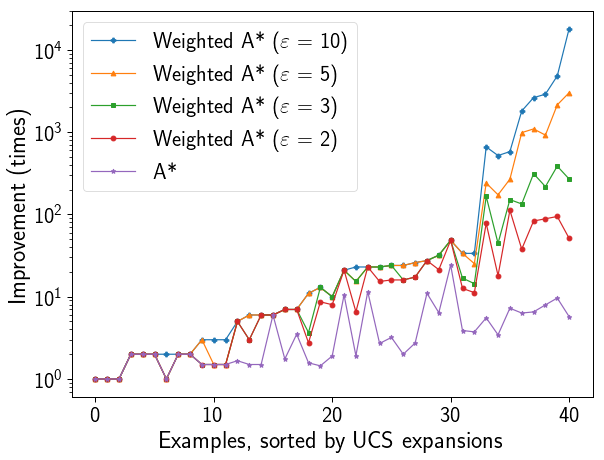

In [18]:
fig, ax = plt.subplots()

for i, eps in reversed(list(enumerate(WEIGHTED_EPSILONS))):
    improv = expansion_improvements_by_eps[eps]
    ax.plot(improv, label='Weighted A* ($\\varepsilon$ = {})'.format(eps),
            marker=MARKERS[i + 2])
    
ax.plot(expansion_improvements_by_eps[1], label='A*', marker=MARKERS[1])
   
ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Improvement (times)')
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'bots_improvement_bin_{}_band_{}_target_{}.pdf', FOCUS_BINS, BAND, TARGET_CONFIDENCE)

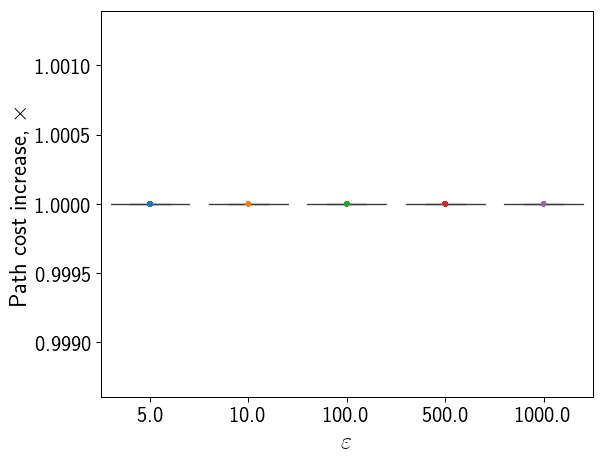

In [19]:
fig, ax = plt.subplots()

data_df = costs_df.query('eps in %s' % HIGH_EPSILONS)
sns.boxplot(data=data_df, x='eps', y='pathcostincrease', ax=ax, showfliers=False)
sns.stripplot(data=data_df, x='eps', y='pathcostincrease', ax=ax, jitter=False)

ax.set_ylabel(r'Path cost increase, $\times$')
ax.set_xlabel(r'$\varepsilon$')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'bots_path_costs_band_{}_target_{}.pdf', BAND, TARGET_CONFIDENCE)

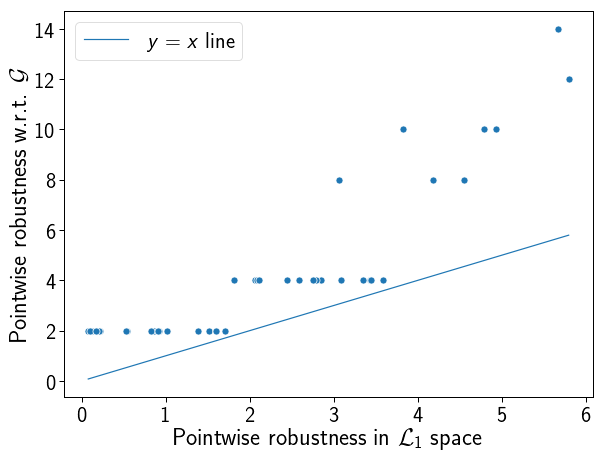

In [20]:
fig, ax = plt.subplots()

ast_costs_df = costs_df.query('eps==1 and bins==%d' % FOCUS_BINS)
sns.scatterplot(data=ast_costs_df,
                x='robustness', y='pathcost',
                s=50,
                ax=ax)

xs = [ast_costs_df.robustness.min(), ast_costs_df.robustness.max()]
plt.plot(xs, xs, label='$y = x$ line')

ax.legend()
ax.set_xlabel('Pointwise robustness in $\mathcal{L}_%s$ space' % P_NORM)
ax.set_ylabel('Pointwise robustness w.r.t. $\mathcal{G}$')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'bots_mac_comparison_band_{}_target_{}.pdf', BAND, TARGET_CONFIDENCE)

(0, 14)

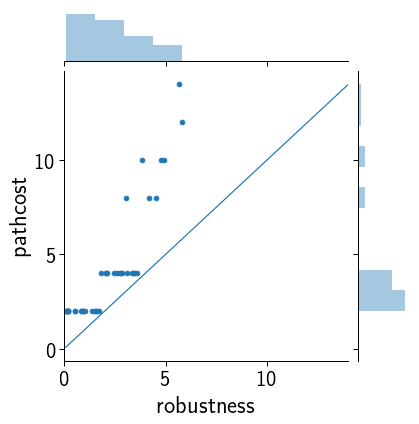

In [21]:
g = sns.jointplot(data=ast_costs_df,
              x='robustness', y='pathcost')

xs = [ast_costs_df.robustness.min(), ast_costs_df.pathcost.max()]
g.ax_joint.plot(xs, xs)
g.ax_marg_x.set_xlim(0, 14)

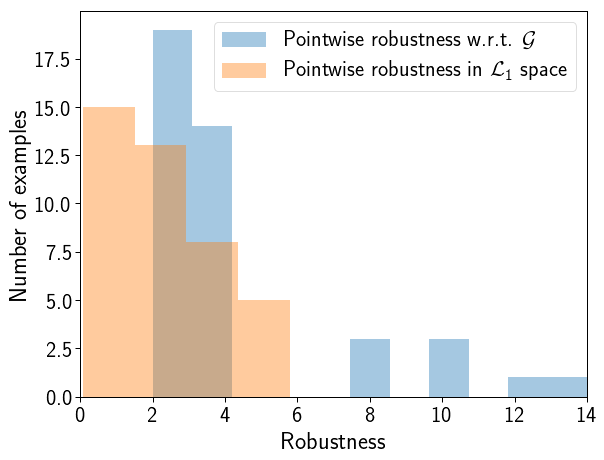

In [22]:
fig, ax = plt.subplots()

sns.distplot(ast_costs_df['pathcost'],
             kde=False,
             label='Pointwise robustness w.r.t. $\mathcal{G}$',
             ax=ax)
sns.distplot(ast_costs_df['robustness'],
             kde=False,
             label='Pointwise robustness in $\mathcal{L}_%s$ space' % P_NORM,
             ax=ax)

ax.set_xlim(0, ast_costs_df.pathcost.max())
ax.set_xlabel('Robustness')
ax.set_ylabel('Number of examples')
ax.legend()

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'bots_mac_distplots_band_{}_target_{}.pdf', BAND, TARGET_CONFIDENCE)

In [23]:
print('Mean robustness:', ast_costs_df['robustness'].mean())

Mean robustness: 2.1846028079455215


In [24]:
print('Mean path cost:', ast_costs_df['pathcost'].mean())

Mean path cost: 4.2439024390243905


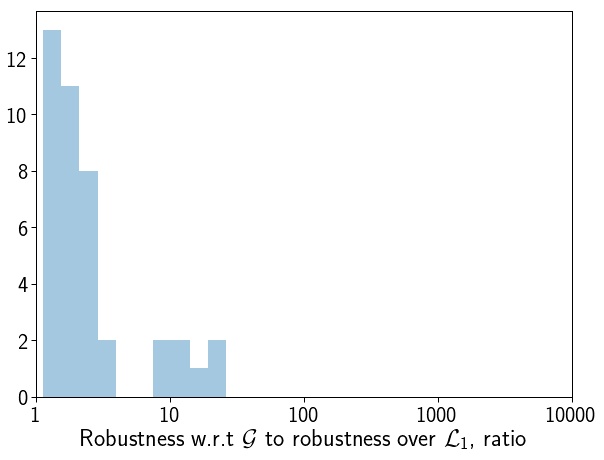

In [25]:
fig, ax = plt.subplots()

ratios = ast_costs_df['pathcost'] / ast_costs_df['robustness']
sns.distplot(np.log10(ratios),
             kde=False,
             ax=ax)

ticks = np.array([0, 1, 2, 3, 4])
ax.set_xticks(ticks)
ax.set_xticklabels(10 ** ticks)
ax.set_xlim(ticks.min(), ticks.max())

ax.set_xlabel(r'Robustness w.r.t $\mathcal{G}$ to robustness over $\mathcal{L}_%s$, ratio' % P_NORM)

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'bots_mac_ratio_band_{}_target_{}.pdf', BAND, TARGET_CONFIDENCE)

In [26]:
df = ast_costs_df.query('robustness > 2')
ratios = df['pathcost'] / df['robustness']

In [27]:
print('Ratios min/mean/max:', ratios.min(), ratios.mean(), ratios.max())

Ratios min/mean/max: 1.1179357352390993 1.7502281785476863 2.619554198535489
